In [1]:
import os
import sys
import json
import numpy as np
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [68]:
gr700_1st = Table.read("dispersion/gr700xd_1_disp.fits")
gr700_2nd = Table.read("dispersion/gr700xd_2_disp.fits")
kmp_1st = Table.read("/Users/pickering/Desktop/gr700xd_1_disp.fits")
kmp_2nd = Table.read("/Users/pickering/Desktop/gr700xd_2_disp.fits")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/pickering/Desktop/gr700xd_1_disp.fits'

In [3]:
from astropy.modeling import models, fitting

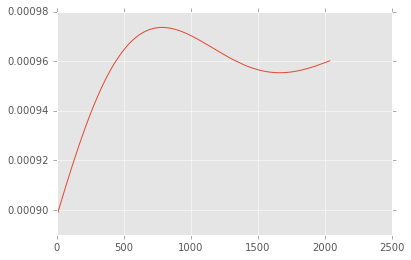

In [4]:
fitter = fitting.LevMarLSQFitter()
dlds_fit1 = fitter(models.Polynomial1D(6), kmp_1st['WAVELENGTH'], kmp_1st['DLDS'])
dlds_fit2 = fitter(models.Polynomial1D(6), kmp_2nd['WAVELENGTH'], kmp_2nd['DLDS'])
r_fit1 = fitter(models.Polynomial1D(6), kmp_1st['WAVELENGTH'], kmp_1st['R'])
r_fit2 = fitter(models.Polynomial1D(6), kmp_2nd['WAVELENGTH'], kmp_2nd['R'])
plt.plot(dlds_fit1(gr700_1st['wavelength']))

In [5]:
gr700_1st['R'] = r_fit1(gr700_1st['wavelength'])
gr700_2nd['R'] = r_fit1(gr700_2nd['wavelength'])
gr700_1st['dlds'] = dlds_fit1(gr700_1st['wavelength'])
gr700_2nd['dlds'] = dlds_fit2(gr700_2nd['wavelength'])
gr700_1st.write("dispersion/gr700xd_1_disp.fits", overwrite=True)
gr700_2nd.write("dispersion/gr700xd_2_disp.fits", overwrite=True)

In [6]:
gr700_1st['wavelength'].min()

0.83089999999999997

In [7]:
mean1 = gr700_1st['dlds'].mean()
mean2 = gr700_2nd['dlds'].mean()

In [8]:
gr700_2nd['dlds'] = mean1 + 0.0*gr700_2nd['wavelength']


In [9]:
gr700_2nd['R'] = gr700_2nd['wavelength'] / (2.0 * gr700_2nd['dlds'])
gr700_1st['R'] = gr700_1st['wavelength'] / (2.0 * gr700_1st['dlds'])
gr700_1st

pixels,wavelength,dlds,R,trace
int64,float64,float64,float64,float64
4,0.8309,0.00089751231863,462.890582532,51.6253929037
5,0.8318,0.000897678366853,463.306252392,51.8058365033
6,0.8328,0.000897862844403,463.767938049,51.9856066727
7,0.8338,0.000898047298795,464.229445999,52.1647052681
8,0.8348,0.000898231728369,464.690777243,52.3431341416
9,0.8357,0.000898397692403,465.105825108,52.5208951413
10,0.8367,0.000898582070282,465.566823372,52.6979901112
11,0.8377,0.000898766418571,466.027647835,52.8744208915
12,0.8386,0.000898932305382,466.442242079,53.050189318


In [10]:
gr700_1st.write("dispersion/gr700xd_1_disp.fits", overwrite=True)
gr700_2nd.write("dispersion/gr700xd_2_disp.fits", overwrite=True)

In [69]:
from pandeia.engine.calc_utils import build_default_calc

In [70]:
calc = build_default_calc(telescope="jwst", instrument="niriss", mode="soss")

In [71]:
from pandeia.engine.scene import Scene
from pandeia.engine.instrument_factory import InstrumentFactory
from pandeia.engine.strategy import StrategyFactory
from pandeia.engine.observation import Observation
from pandeia.engine.etc3D import CalculationConfig, DetectorSignal, CombinedSignal, DetectorNoise

In [72]:
scene = Scene(input=calc['scene'])
instrument = InstrumentFactory(config=calc['configuration'])
strategy = StrategyFactory(instrument, config=calc['strategy'])
obs = Observation(scene=scene, instrument=instrument, strategy=strategy, background=calc['background'])
seed = obs.get_random_seed()
np.random.seed(seed=seed)

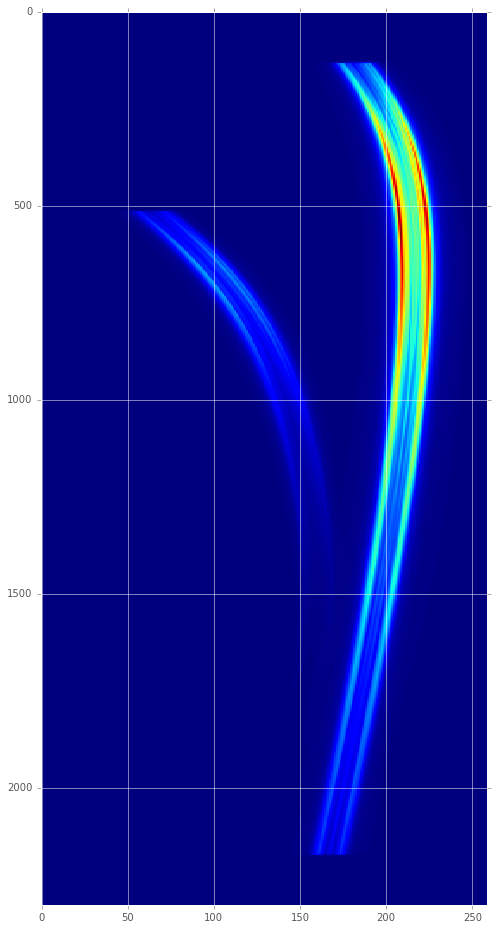

In [73]:
plt.figure(figsize=(8,16))
s1 = DetectorSignal(obs, calc_config=CalculationConfig(), order=1)
s2 = DetectorSignal(obs, calc_config=CalculationConfig(), order=2)
s = CombinedSignal([s1, s2])
plt.imshow(s.rate, aspect=2.0*s.rate.shape[1]/s.rate.shape[0], interpolation='nearest')

In [74]:
s = CombinedSignal([s1, s2])
n = DetectorNoise(s, obs)

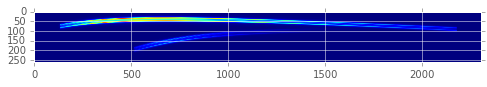

In [82]:
plt.figure(figsize=(8,16))
plt.imshow(np.rot90(n.var_pix))

In [76]:
e = strategy.extract([s], [n])
e

{'detector_noise': array([[ 0.31976372,  0.31976372,  0.31976372, ...,  0.31976372,
          0.31976372,  0.31976372],
        [ 0.31976372,  0.31976372,  0.31976372, ...,  0.31976372,
          0.31976372,  0.31976372],
        [ 0.31976372,  0.31976372,  0.31976372, ...,  0.31976372,
          0.31976372,  0.31976372],
        ..., 
        [ 0.31976372,  0.31976372,  0.31976372, ...,  0.31976372,
          0.31976372,  0.31976372],
        [ 0.31976372,  0.31976372,  0.31976372, ...,  0.31976372,
          0.31976372,  0.31976372],
        [ 0.31976372,  0.31976372,  0.31976372, ...,  0.31976372,
          0.31976372,  0.31976372]]),
 'detector_signal': array([[ 2.1875376,  2.1875376,  2.1875376, ...,  2.1875376,  2.1875376,
          2.1875376],
        [ 2.1875376,  2.1875376,  2.1875376, ...,  2.1875376,  2.1875376,
          2.1875376],
        [ 2.1875376,  2.1875376,  2.1875376, ...,  2.1875376,  2.1875376,
          2.1875376],
        ..., 
        [ 2.1875376,  2.1875376, 

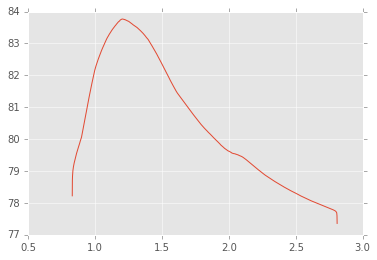

In [79]:
plt.plot(e['wavelength'], e['extracted_flux'])

In [18]:
from astropy.io import fits

In [41]:
fits.writeto("blah.fits", s.rate_plus_bg)

In [17]:
new_wave_pix = Table.read("/Users/pickering/STScI/smite/pandeia_data/devtools/delivered/niriss/lambda_solution.txt", format='ascii.basic')

In [18]:
new_wave_pix

ypixel,lambda_order1_nm,lambda_order2_nm,lambda_order3_nm
int64,float64,float64,float64
0,827.0,0.0,0.0
1,828.0,0.0,0.0
2,828.9,0.0,0.0
3,829.9,0.0,0.0
4,830.9,0.0,0.0
5,831.8,0.0,0.0
6,832.8,0.0,0.0
7,833.8,0.0,0.0
8,834.8,0.0,0.0


In [19]:
from astropy.io import fits

In [20]:
mask_1 = fits.open("/Users/pickering/STScI/smite/pandeia_data/devtools/delivered/niriss/mask_order1_35pixels.fits")[0].data
mask_2 = fits.open("/Users/pickering/STScI/smite/pandeia_data/devtools/delivered/niriss/mask_order2_35pixels.fits")[0].data
mask_3 = fits.open("/Users/pickering/STScI/smite/pandeia_data/devtools/delivered/niriss/mask_order3_35pixels.fits")[0].data

In [21]:
mask_1.shape

(2048, 256)

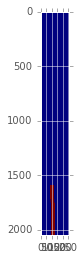

In [22]:
plt.imshow(mask_3)

In [23]:
pos_1 = []
pos_2 = []
pos_3 = []
for i in new_wave_pix['ypixel']:
    row_1 = mask_1[i, :]
    row_2 = mask_2[i, :]
    row_3 = mask_3[i, :]
    nx = len(row_1)
    pos_1.append( (row_1 * np.arange(nx))[row_1 > 0].mean() )
    pos_2.append( (row_2 * np.arange(nx))[row_2 > 0].mean() )
    pos_3.append( (row_3 * np.arange(nx))[row_3 > 0].mean() )
pos_1 = np.array(pos_1)
pos_2 = np.array(pos_2)
pos_3 = np.array(pos_3)

/Users/pickering/miniconda3/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/pickering/miniconda3/lib/python3.4/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


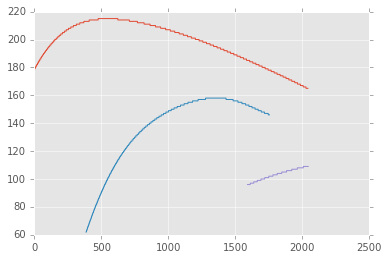

In [24]:
plt.plot(pos_1)
plt.plot(pos_2)
plt.plot(pos_3)

In [25]:
len(pos_3)

2048

In [26]:
new_wave_pix['tracex_order1'] = pos_1
new_wave_pix['tracex_order2'] = pos_2
new_wave_pix['tracex_order3'] = pos_3

In [27]:
new_wave_pix

ypixel,lambda_order1_nm,lambda_order2_nm,lambda_order3_nm,tracex_order1,tracex_order2,tracex_order3
int64,float64,float64,float64,float64,float64,float64
0,827.0,0.0,0.0,nan,nan,nan
1,828.0,0.0,0.0,nan,nan,nan
2,828.9,0.0,0.0,nan,nan,nan
3,829.9,0.0,0.0,nan,nan,nan
4,830.9,0.0,0.0,179.0,nan,nan
5,831.8,0.0,0.0,179.0,nan,nan
6,832.8,0.0,0.0,179.0,nan,nan
7,833.8,0.0,0.0,180.0,nan,nan
8,834.8,0.0,0.0,180.0,nan,nan


In [28]:
new_wave_pix.write("gr700xd_trace.fits")

In [29]:
trace = Table(new_wave_pix, masked=True)

In [30]:
trace

ypixel,lambda_order1_nm,lambda_order2_nm,lambda_order3_nm,tracex_order1,tracex_order2,tracex_order3
int64,float64,float64,float64,float64,float64,float64
0,827.0,0.0,0.0,nan,nan,nan
1,828.0,0.0,0.0,nan,nan,nan
2,828.9,0.0,0.0,nan,nan,nan
3,829.9,0.0,0.0,nan,nan,nan
4,830.9,0.0,0.0,179.0,nan,nan
5,831.8,0.0,0.0,179.0,nan,nan
6,832.8,0.0,0.0,179.0,nan,nan
7,833.8,0.0,0.0,180.0,nan,nan
8,834.8,0.0,0.0,180.0,nan,nan


In [31]:
m1 = pos_1 > 0
m2 = pos_2 > 0
m3 = pos_3 > 0

/Users/pickering/miniconda3/lib/python3.4/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/pickering/miniconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Users/pickering/miniconda3/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


In [32]:
trace['lambda_order1_nm'].mask = np.logical_not(m1)
trace['lambda_order1_nm'] /= 1000.0
trace.rename_column('lambda_order1_nm', 'wavelength_order1')
trace['tracex_order1'].mask = np.logical_not(m1)
trace['lambda_order2_nm'].mask = np.logical_not(m2)
trace['lambda_order2_nm'] /= 1000.0
trace.rename_column('lambda_order2_nm', 'wavelength_order2')
trace['tracex_order2'].mask = np.logical_not(m2)
trace['lambda_order3_nm'].mask = np.logical_not(m3)
trace['lambda_order3_nm'] /= 1000.0
trace.rename_column('lambda_order3_nm', 'wavelength_order3')
trace['tracex_order3'].mask = np.logical_not(m3)

In [33]:
dlds_1 = np.diff(trace['wavelength_order1'])
dlds_2 = np.diff(trace['wavelength_order2'])
dlds_3 = np.diff(trace['wavelength_order3'])

In [34]:
wave_start1 = trace['wavelength_order1'].argmin()
wave_start2 = trace['wavelength_order2'].argmin()
wave_start3 = trace['wavelength_order3'].argmin()

In [35]:
trace['dlds_order1'] = dlds_1.insert(wave_start1, dlds_1[wave_start1])
trace['dlds_order2'] = dlds_2.insert(wave_start2, dlds_2[wave_start2])
trace['dlds_order3'] = dlds_3.insert(wave_start3, dlds_3[wave_start3])

In [36]:
trace['R_order1'] = trace['wavelength_order1'] / (2.0 * trace['dlds_order1'])
trace['R_order2'] = trace['wavelength_order2'] / (2.0 * trace['dlds_order2'])
trace['R_order3'] = trace['wavelength_order3'] / (2.0 * trace['dlds_order3'])

In [37]:
trace

ypixel,wavelength_order1,wavelength_order2,wavelength_order3,tracex_order1,tracex_order2,tracex_order3,dlds_order1,dlds_order2,dlds_order3,R_order1,R_order2,R_order3
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,--,--,--,--,--,--,--,--,--,--,--,--
1,--,--,--,--,--,--,--,--,--,--,--,--
2,--,--,--,--,--,--,--,--,--,--,--,--
3,--,--,--,--,--,--,--,--,--,--,--,--
4,0.8309,--,--,179.0,--,--,0.0009,--,--,461.611111111,--,--
5,0.8318,--,--,179.0,--,--,0.0009,--,--,462.111111111,--,--
6,0.8328,--,--,179.0,--,--,0.001,--,--,416.4,--,--
7,0.8338,--,--,180.0,--,--,0.001,--,--,416.9,--,--
8,0.8348,--,--,180.0,--,--,0.001,--,--,417.4,--,--


In [38]:
trace.write("gr700xd.fits", overwrite=True)

In [71]:
order1 = Table()
order2 = Table()
order3 = Table()
w1 = trace['wavelength_order1']
w2 = trace['wavelength_order2']
w3 = trace['wavelength_order3']
index1 = np.where(w1.mask == False)
index2 = np.where(w2.mask == False)
index3 = np.where(w3.mask == False)
w1 = w1[index1]
w2 = w2[index2]
w3 = w3[index3]
d1 = trace['dlds_order1'][index1]
d2 = trace['dlds_order2'][index2]
d3 = trace['dlds_order3'][index3]
r1 = trace['R_order1'][index1]
r2 = trace['R_order2'][index2]
r3 = trace['R_order3'][index3]
p1 = trace['ypixel'][index1]
p2 = trace['ypixel'][index2]
p3 = trace['ypixel'][index3]

In [72]:
order1['pixels'] = p1
order2['pixels'] = p2
order3['pixels'] = p3
order1['wavelength'] = w1
order2['wavelength'] = w2
order3['wavelength'] = w3
order1['dlds'] = d1
order2['dlds'] = d2
order3['dlds'] = d3
order1['R'] = r1
order2['R'] = r2
order3['R'] = r3
order1.write("gr700xd_1_disp.fits")
order2.write("gr700xd_2_disp.fits")
order3.write("gr700xd_3_disp.fits")

In [83]:
soss_im = s.rate

In [124]:
from scipy.ndimage.interpolation import geometric_transform, shift
from astropy.modeling import models, fitting

In [116]:
def xshift(out_coo, shifts):
    xs = shifts - 128.5
    return (out_coo[0], out_coo[1] - xs[out_coo[0]])

In [167]:
dx1 = trace['tracex_order1'][index1].data.data
dx2 = trace['tracex_order2'][index2].data.data
dx3 = trace['tracex_order3'][index3].data.data
fitter = fitting.LevMarLSQFitter()
trace_fit1 = fitter(models.Polynomial1D(6), p1, dx1)
trace_fit2 = fitter(models.Polynomial1D(6), p2, dx2)
trace_fit3 = fitter(models.Polynomial1D(6), p3, dx3)
diff = trace_fit(p1) - dx
#plt.plot(p1, diff)
dx_fit = trace_fit3(p3)
order1['trace'] = trace_fit1(p1) - 127.5
order2['trace'] = trace_fit2(p2) - 127.5
order3['trace'] = trace_fit3(p3) - 127.5
order1.write("gr700xd_1_disp.fits")
order2.write("gr700xd_2_disp.fits")
order3.write("gr700xd_3_disp.fits")

In [97]:
soss_trim = soss_im[128:-129, :]

In [160]:
soss_trim.sum()

7082.2468844472696

In [145]:
soss_sh = geometric_transform(soss_trim, xshift, extra_arguments=(trace_fit(dx_fit),))

In [81]:
plt.figure(figsize=(8,16))
plt.imshow(np.rot90(soss_sh), aspect=0.5*s.rate.shape[1]/s.rate.shape[0], interpolation='nearest')

[autoreload of PIL.Image failed: Traceback (most recent call last):
  File "/Users/pickering/miniconda3/lib/python3.4/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name '_imaging'
]


NameError: name 'soss_sh' is not defined

In [120]:
pos_1[5]

179.0

In [158]:
Table.read("gr700xd_2_disp.fits")

pixels,wavelength,dlds,R,trace
int64,float64,float64,float64,float64
386,0.6352,0.0004,794.0,61.6494383593
387,0.6356,0.0004,794.5,61.93156845
388,0.6361,0.0005,636.1,62.2131586354
389,0.6366,0.0005,636.6,62.4942082462
390,0.637,0.0004,796.25,62.7747166253
391,0.6375,0.0005,637.5,63.0546831279
392,0.6379,0.0004,797.375,63.3341071214
393,0.6384,0.0005,638.4,63.6129879851
394,0.6388,0.0004,798.5,63.8913251106


In [161]:
soss_im.sum()

7085.1702943132086

In [162]:
soss_sh.sum()

7082.2468844417554

In [164]:
soss_sh.shape

(2040, 257)

In [165]:
mask_1.shape

(2048, 256)

In [166]:
255/2

127.5

In [168]:
len(1.0)

TypeError: object of type 'float' has no len()

In [169]:
soss_im[128.5:, :]

/Users/pickering/miniconda3/lib/python3.4/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


array([[  2.39998235e-19,   2.52549073e-17,   1.37865385e-18, ...,
          7.61443765e-18,   5.09818389e-18,   1.59040705e-17],
       [ -4.35418368e-18,   3.14738992e-17,   1.12575028e-17, ...,
          5.13210331e-18,  -1.09844681e-18,   4.61625549e-18],
       [ -2.52369962e-17,   3.22895413e-18,  -7.88230709e-18, ...,
         -1.79979476e-17,  -1.38821039e-17,  -1.69257742e-17],
       ..., 
       [ -1.70314988e-17,   4.82300822e-19,  -1.31470052e-17, ...,
         -1.30871710e-17,  -6.26409756e-18,  -1.52451160e-17],
       [ -3.37208235e-18,   1.57158208e-17,   7.50314631e-18, ...,
         -3.04736063e-18,   5.35031988e-18,  -2.12354760e-18],
       [ -8.67239329e-18,   9.32200432e-18,  -2.94618135e-18, ...,
         -1.13988664e-17,  -4.30615462e-18,  -1.12534365e-17]])

In [172]:
soss_im.shape

(2297, 257)

In [178]:
int(np.floor(-128.5))

-129

In [33]:
np.zeros_like?

In [41]:
'A'.lower()

'a'

In [47]:
from astropy.io import fits

In [49]:
f = fits.getdata("dispersion/gr700xd_1_disp.fits")

In [52]:
for c in f.columns:
    print(c.name.lower())

pixels
wavelength
dlds
r
trace


In [60]:
a = np.arange(5)

In [61]:
a[0:10]

array([0, 1, 2, 3, 4])

In [35]:
from pandeia.engine.coords import IrregularGrid

In [36]:
g = IrregularGrid(np.arange(10), np.arange(20))

In [37]:
g.y

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.],
       [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
         4.,  4.,  4.,  4.,  4.,  4.,  4.],
       [ 5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
         5.,  5.,  5.,  5.,  5.,  5.,  5.],
       [ 6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
         6.,  6.,  6.,  6.,  6.,  6.,  6.],
       [ 7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.,  7.,  7.,  7.,  7.,  7.],
       [ 8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  

In [38]:
np.ones_like?

In [39]:
np.zeros_like(g.y)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

In [26]:
a = np.arange(25).reshape(5, 5)

In [30]:
np.pad(a, ([2,2], [0,0]), mode='edge')

array([[ 0,  1,  2,  3,  4],
       [ 0,  1,  2,  3,  4],
       [ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24],
       [20, 21, 22, 23, 24],
       [20, 21, 22, 23, 24]])

In [73]:
gr3 = Table.read("dispersion/gr700xd_3_disp.fits")
mean = gr3['dlds'].mean()
gr3['dlds'] = mean
gr3.write("dispersion/gr700xd_3_disp.fits", overwrite=True)

In [71]:
mean

0.00032026431718061669

In [121]:
floor(127.5)

NameError: name 'floor' is not defined

In [128]:
a = np.ones(25).reshape(5, 5)
b = np.ones(36).reshape(6, 6)

In [130]:
b[:, 0:-1].shape

(6, 5)

In [132]:
s.wave_pix_list[0].shape

(2040,)

In [134]:
s.rate.shape

(2303, 259)

In [55]:
fits.writeto?

In [80]:
calc

{'background': 'medium',
 'calculation': {'effects': {'background': True,
   'ipc': True,
   'saturation': True},
  'noise': {'crs': False,
   'darkcurrent': True,
   'ffnoise': True,
   'readnoise': True,
   'rn_correlation': True}},
 'configuration': {'detector': {'nexp': 1,
   'ngroup': 10,
   'nint': 1,
   'readmode': 'nis',
   'subarray': 'substrip256'},
  'dynamic_scene': True,
  'instrument': {'aperture': 'soss',
   'disperser': 'gr700xd',
   'filter': None,
   'instrument': 'niriss',
   'mode': 'soss'},
  'max_scene_size': 16.9,
  'scene_size': 16.9},
 'scene': [{'id': 1,
   'position': {'orientation': 0.0, 'x_offset': 0.0, 'y_offset': 0.0},
   'shape': {'geometry': 'point'},
   'spectrum': {'lines': [],
    'name': 'generic source',
    'normalization': {'norm_flux': 0.1,
     'norm_fluxunit': 'mjy',
     'norm_wave': 2.0,
     'norm_waveunit': 'microns',
     'type': 'at_lambda'},
    'sed': {'sed_type': 'flat', 'unit': 'fnu'}}}],
 'strategy': {'background_subtraction': False

In [ ]:
dir tm